In [91]:
import os
import re
from pathlib import Path
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [92]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [93]:
def is_gzip_file(filepath):
    with open(filepath, 'rb') as f:
        return f.read(2) == b'\x1f\x8b'
def display_all(df):
    plot_cols = df.columns
    plot_features = df[plot_cols]
    plot_features.index = df.index
    _ = plot_features.plot(subplots=True)

    plot_features = df[plot_cols][:960]
    plot_features.index = df.index[:960]
    _ = plot_features.plot(subplots=True)

In [117]:
csv_path = tf.keras.utils.get_file(
    #origin='https://itsci.mju.ac.th/downloads/watcharin/datasets/pv/sis_selected_timeseries.csv.tar.gz')
    origin='https://itsci.mju.ac.th/downloads/watcharin/datasets/pv/utci_selected_timeseries_filled.csv.zip')
    #origin='https://itsci.mju.ac.th/downloads/watcharin/datasets/pv/era5-hourly_timeseries_filled.csv.zip')
    #origin='https://itsci.mju.ac.th/downloads/watcharin/datasets/pv/era5-land_timeseries_filled.csv.zip')
csv_path

406191/406191 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


'/Users/watcharinsarachai/.keras/datasets/utci_selected_timeseries_filled.csv.zip'

In [118]:
date_col = 'datetime' 
if is_gzip_file(csv_path):
  # Read the data directly into a pandas DataFrame
  df = pd.read_csv(csv_path, compression='gzip')
else:
  # Read the data without compression
  df = pd.read_csv(csv_path)
df = df.rename(columns={df.columns[0]: date_col})

# Ensure timestamp column is datetime type
if df[date_col].dtype != 'datetime64[ns]':
    df[date_col] = pd.to_datetime(df[date_col])
    
row_count = df.shape[0]
print(f"Total rows: {row_count}")
df.head(5)

Total rows: 57696


,datetime,utci_mean
0,2019-01-01 00:00:00,291.970684
1,2019-01-01 01:00:00,294.052976
2,2019-01-01 02:00:00,296.218970
3,2019-01-01 03:00:00,298.282307
4,2019-01-01 04:00:00,301.553607


In [119]:
print(df[date_col].dt.year.unique())
print(df[date_col].dt.year.value_counts())

[2019 2020 2021 2022 2023 2024 2025]
datetime
2020    8784
2024    8784
2019    8760
2021    8760
2022    8760
2023    8760
2025    5088
Name: count, dtype: int64


In [120]:
df.shape

(57696, 2)

In [121]:
# Sort by time if it exists
df.index = df[date_col]
df.pop(date_col)
df = df.sort_index()
print(df.shape)
df.head(5)

(57696, 1)


,utci_mean
datetime,
2019-01-01 00:00:00,291.970684
2019-01-01 01:00:00,294.052976
2019-01-01 02:00:00,296.218970
2019-01-01 03:00:00,298.282307
2019-01-01 04:00:00,301.553607


In [122]:
# Ensure index has no duplicates before reindexing
dup_cnt = df.index.duplicated().sum()
if dup_cnt:
  print(f"Found {dup_cnt} duplicate timestamps; keeping first occurrence")
  df = df[~df.index.duplicated(keep='first')]
  print(df.shape)

In [123]:
# Upsample from hourly to 15-minute resolution
# Create 15-minute index spanning the full range
start = df.index.min()
end = df.index.max()
freq_15min = pd.date_range(start=start, end=end, freq='15min')
freq_15min

DatetimeIndex(['2019-01-01 00:00:00', '2019-01-01 00:15:00',
               '2019-01-01 00:30:00', '2019-01-01 00:45:00',
               '2019-01-01 01:00:00', '2019-01-01 01:15:00',
               '2019-01-01 01:30:00', '2019-01-01 01:45:00',
               '2019-01-01 02:00:00', '2019-01-01 02:15:00',
               ...
               '2025-07-31 20:45:00', '2025-07-31 21:00:00',
               '2025-07-31 21:15:00', '2025-07-31 21:30:00',
               '2025-07-31 21:45:00', '2025-07-31 22:00:00',
               '2025-07-31 22:15:00', '2025-07-31 22:30:00',
               '2025-07-31 22:45:00', '2025-07-31 23:00:00'],
              dtype='datetime64[ns]', length=230781, freq='15min')

In [124]:
# Ensure index is sorted (monotonic) for reindex with ffill
if not df.index.is_monotonic_increasing:
  print("Sorting index to ensure monotonic order")
  df = df.sort_index()

In [125]:
# Reindex and forward-fill (each hour's values replicate to all 4 quarters)
df_15min = df.reindex(freq_15min, method='ffill')

print(f"Original hourly rows: {len(df)}")
print(f"Upsampled 15-min rows: {len(df_15min)}")
df_15min.head(8)  # Show first 2 hours = 8 x 15min rows

Original hourly rows: 57696
Upsampled 15-min rows: 230781


,utci_mean
2019-01-01 00:00:00,291.970684
2019-01-01 00:15:00,291.970684
2019-01-01 00:30:00,291.970684
2019-01-01 00:45:00,291.970684
2019-01-01 01:00:00,294.052976
2019-01-01 01:15:00,294.052976
2019-01-01 01:30:00,294.052976
2019-01-01 01:45:00,294.052976


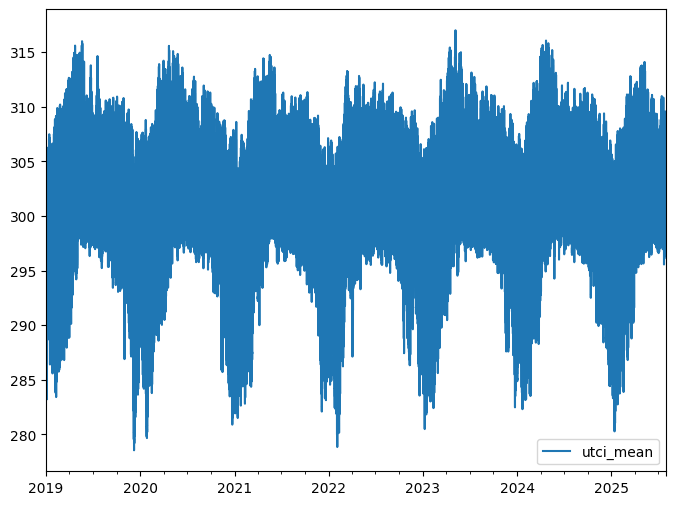

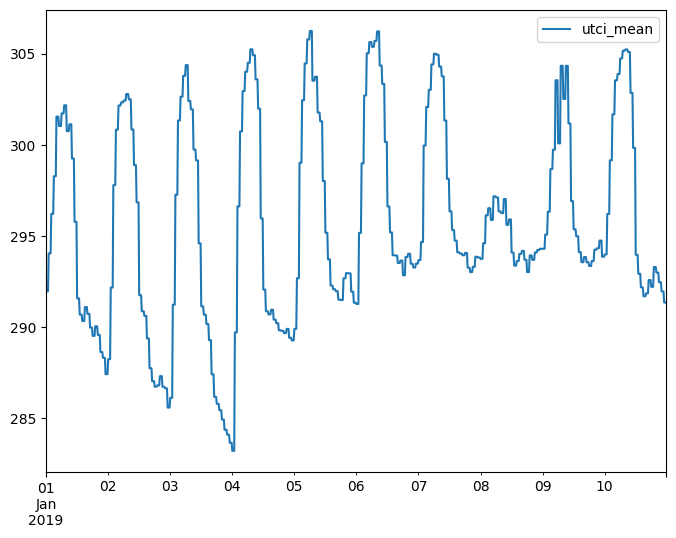

In [126]:
display_all(df_15min)

In [127]:
filename = Path(csv_path).name
base = re.split(r'\.', filename, 1)[0]
print(base)

utci_selected_timeseries_filled


In [128]:
# Compressed CSV
df_15min.to_csv(base + '_15min.csv')